In [1]:
import sys
sys.path.append('src')

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from pathlib import Path
import typing

from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

from timething import dataset, job, text, utils, align, prealign, viz  # type: ignore

# Align a Podcast

We would like to be able to align real-world data. That means longer tracks, along with real transcriptions. We'll be working with a podcast here. First, the config:

In [4]:
fixtures_path = Path("fixtures")
metadata = fixtures_path / "keanu.csv"
cfg = utils.load_config("english")
ds = dataset.SpeechDataset(Path(metadata), cfg.sampling_rate)
device = "cpu"

The aligner:

In [5]:
aligner = align.Aligner.build(device, cfg)
loader = DataLoader(
    ds,
    batch_size=1,
    num_workers=1,
    collate_fn=dataset.collate_fn,
    shuffle=False,
)

/Users/ranykeddo/anaconda3/envs/timething/lib/python3.8/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


Cleaner:

In [6]:
clean_text_fn = text.TextCleaner(cfg.language, aligner.vocab)

The data:

In [60]:
batch = next(iter(loader))
xs, ys, ys_original, ids = batch

We have around 30 minutes of audio:

In [8]:
n_seconds = len(xs.squeeze()) / cfg.sampling_rate
n_minutes = n_seconds / 60
f"{n_minutes:.2f} minutes of audio"

'26.22 minutes of audio'

In [9]:
def audio_window(xs, offset_seconds, length_seconds, cfg):
    "A smaller window of audio snipped out of x"
    offset = cfg.sampling_rate * offset_seconds
    duration = cfg.sampling_rate * length_seconds
    return xs[:, :, offset:(offset+duration)]

offset_seconds = 100
length_seconds = 10
snippet = audio_window(xs, offset_seconds, length_seconds, cfg)

Let's have a listen:

In [10]:
ipd.Audio(snippet.squeeze(), rate=cfg.sampling_rate)

In [11]:
logprobs = aligner.logp(snippet)
logprobs

tensor([[[-4.4920e-04, -2.4794e+01, -2.4756e+01,  ..., -1.5488e+01,
          -1.2998e+01, -1.5023e+01],
         [-6.5484e-04, -2.5985e+01, -2.5978e+01,  ..., -1.6030e+01,
          -1.3919e+01, -1.5904e+01],
         [-1.2083e-03, -2.6934e+01, -2.6883e+01,  ..., -1.6240e+01,
          -1.3829e+01, -1.6406e+01],
         ...,
         [-6.1922e-04, -2.9404e+01, -2.9455e+01,  ..., -1.7150e+01,
          -1.3983e+01, -1.7278e+01],
         [-7.1391e+00, -2.4345e+01, -2.4284e+01,  ..., -1.5324e+01,
          -1.3572e+01, -1.6541e+01],
         [-1.2773e-03, -2.7857e+01, -2.7881e+01,  ..., -1.7223e+01,
          -1.4176e+01, -1.6477e+01]]])

Let's argmax decode this snippet:

In [12]:
prediction = prealign.decode_best(logprobs, aligner.vocab).lower()
transcript = ys[0].lower()
prediction

"rt oan think part of your feeling that you can't rt of look right at him that he doesn't certain it's almost like your interest kind of glances off of him i think is "

In [13]:
# Let's check out the query windows we are using for this search:
n_chars = 80
query_windows = prealign.windows(prediction, n_chars=n_chars)

# show all query windows
query_windows

["rt oan think part of your feeling that you can't rt of look right at him that he",
 "ou can't rt of look right at him that he doesn't certain it's almost like your i",
 " doesn't certain it's almost like your interest kind of glances off of him i thi",
 'nterest kind of glances off of him i think is ']

In [14]:
transcript_windows = prealign.windows(transcript, n_chars=n_chars)

# show a few transcript windows
transcript_windows[:10]

['wesley morris alex pappademas, you’ve written a book. alex pappademas yeah, how ',
 'itten a book. alex pappademas yeah, how about that? wesley morris it’s called “k',
 'about that? wesley morris it’s called “keanu reeves: most triumphant: the movies',
 'eanu reeves: most triumphant: the movies and meaning of an irrepressible icon.” ',
 ' and meaning of an irrepressible icon.” but i have a question for you. is it pos',
 'but i have a question for you. is it possible to even get near the bottom of kea',
 'sible to even get near the bottom of keanu reeves? alex pappademas i think he mi',
 'nu reeves? alex pappademas i think he might be an unknowable icon. i sit before ',
 'ght be an unknowable icon. i sit before you as someone who’s thought about him f',
 'you as someone who’s thought about him for a whole year, and i don’t know if i k']

Let's search:

In [15]:
n_chars = 80
print(prediction)
matches = list(prealign.similarity(prediction, transcript, n_chars=n_chars, threshold=0.3))
for m in matches:
    q, t, prob = m
    print(f"\n----MATCH (probability {prob})\n\nQUERY WINDOW \n'{query_windows[q]}'\n\nTRANSCRIPT WINDOW \n'{transcript_windows[t]}'\n")

rt oan think part of your feeling that you can't rt of look right at him that he doesn't certain it's almost like your interest kind of glances off of him i think is 

----MATCH (probability 0.47572815533980584)

QUERY WINDOW 
'rt oan think part of your feeling that you can't rt of look right at him that he'

TRANSCRIPT WINDOW 
'of it, i think. and i think part of your feeling that you can’t look right at hi'


----MATCH (probability 0.3559322033898305)

QUERY WINDOW 
' doesn't certain it's almost like your interest kind of glances off of him i thi'

TRANSCRIPT WINDOW 
'm, and that he doesn’t — it’s almost like your interest glances off of him, i th'



In [44]:
print(f"matching {len(query_windows)} query windows against {len(transcript_windows)} transcript windows")
full_matches = list(prealign.similarity(prediction, transcript, n_chars=n_chars, threshold=0.08))
full_matches

matching 4 query windows against 600 transcript windows


[(0, 30, 0.13076923076923078),
 (0, 31, 0.47572815533980584),
 (0, 32, 0.2727272727272727),
 (0, 48, 0.09154929577464789),
 (0, 49, 0.1079136690647482),
 (0, 54, 0.09090909090909091),
 (0, 55, 0.09285714285714286),
 (0, 338, 0.08391608391608392),
 (1, 31, 0.16417910447761194),
 (1, 32, 0.27419354838709675),
 (1, 33, 0.19402985074626866),
 (2, 33, 0.3559322033898305),
 (2, 34, 0.23076923076923078),
 (3, 33, 0.18867924528301888),
 (3, 34, 0.24752475247524752)]

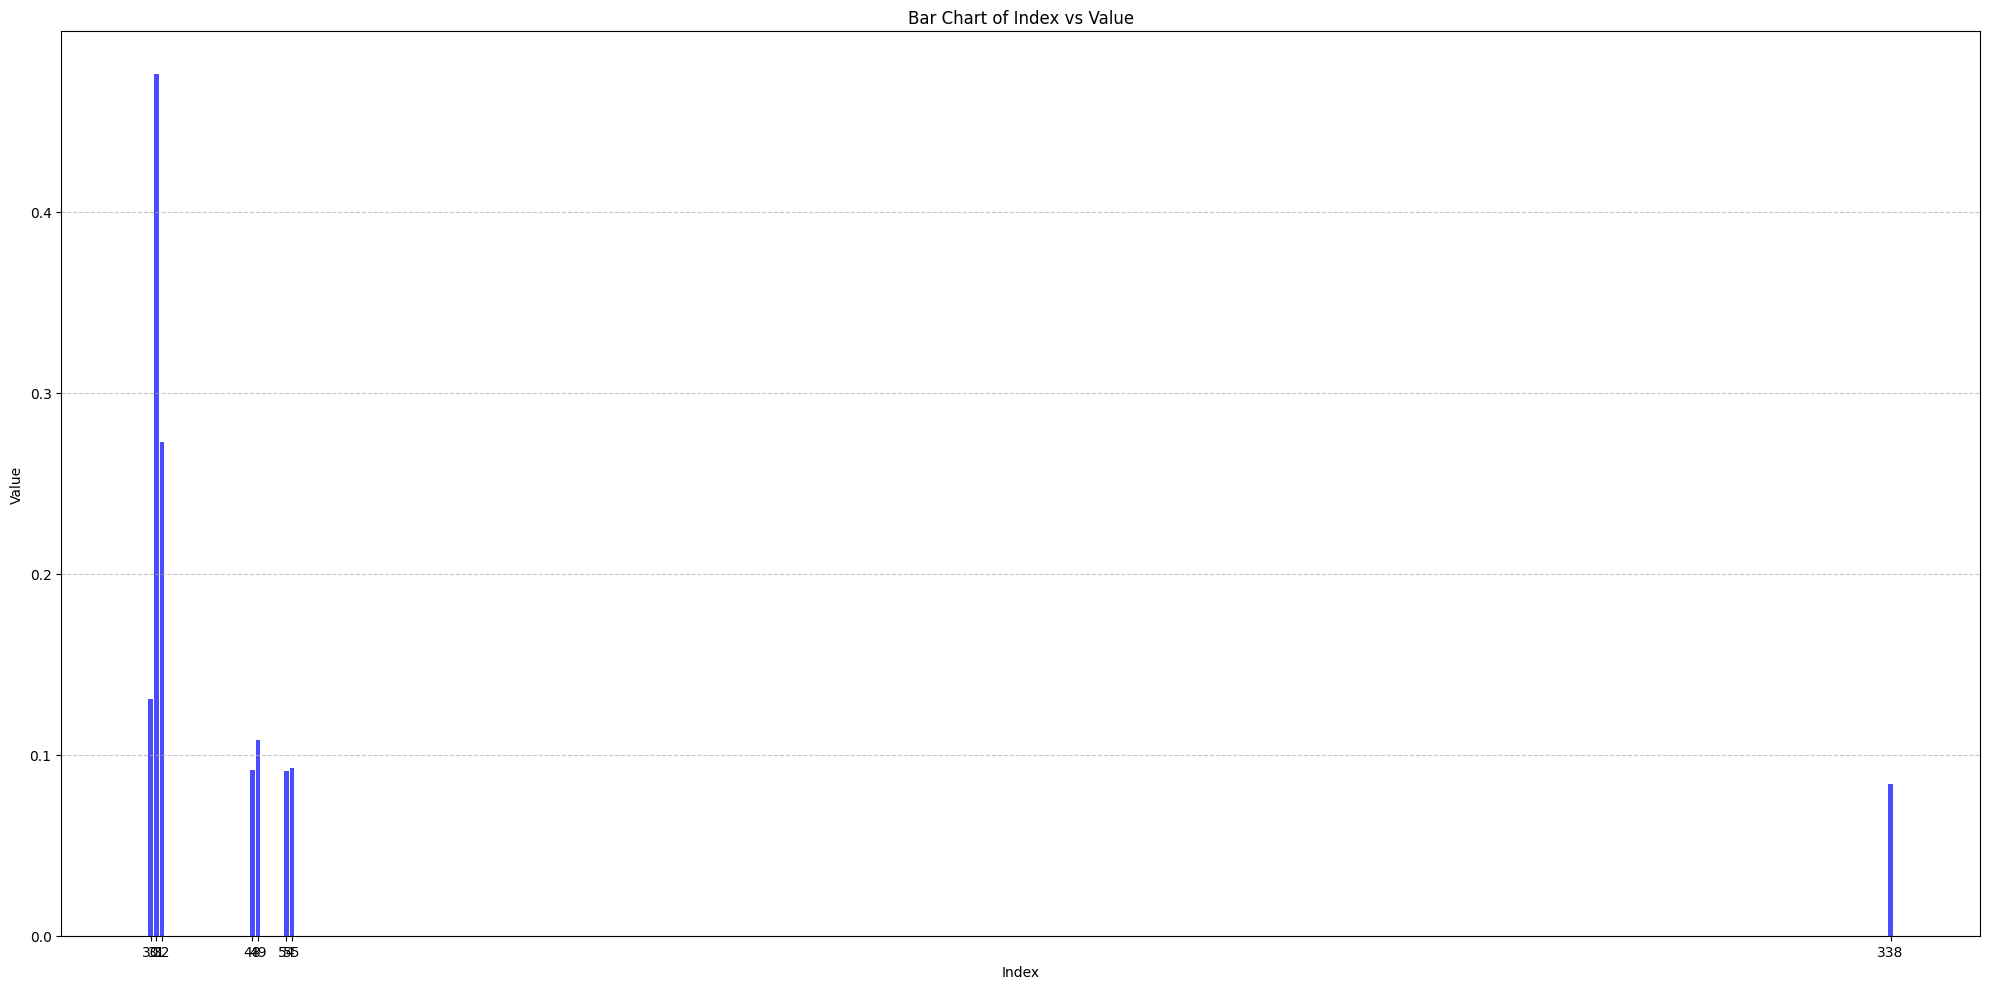

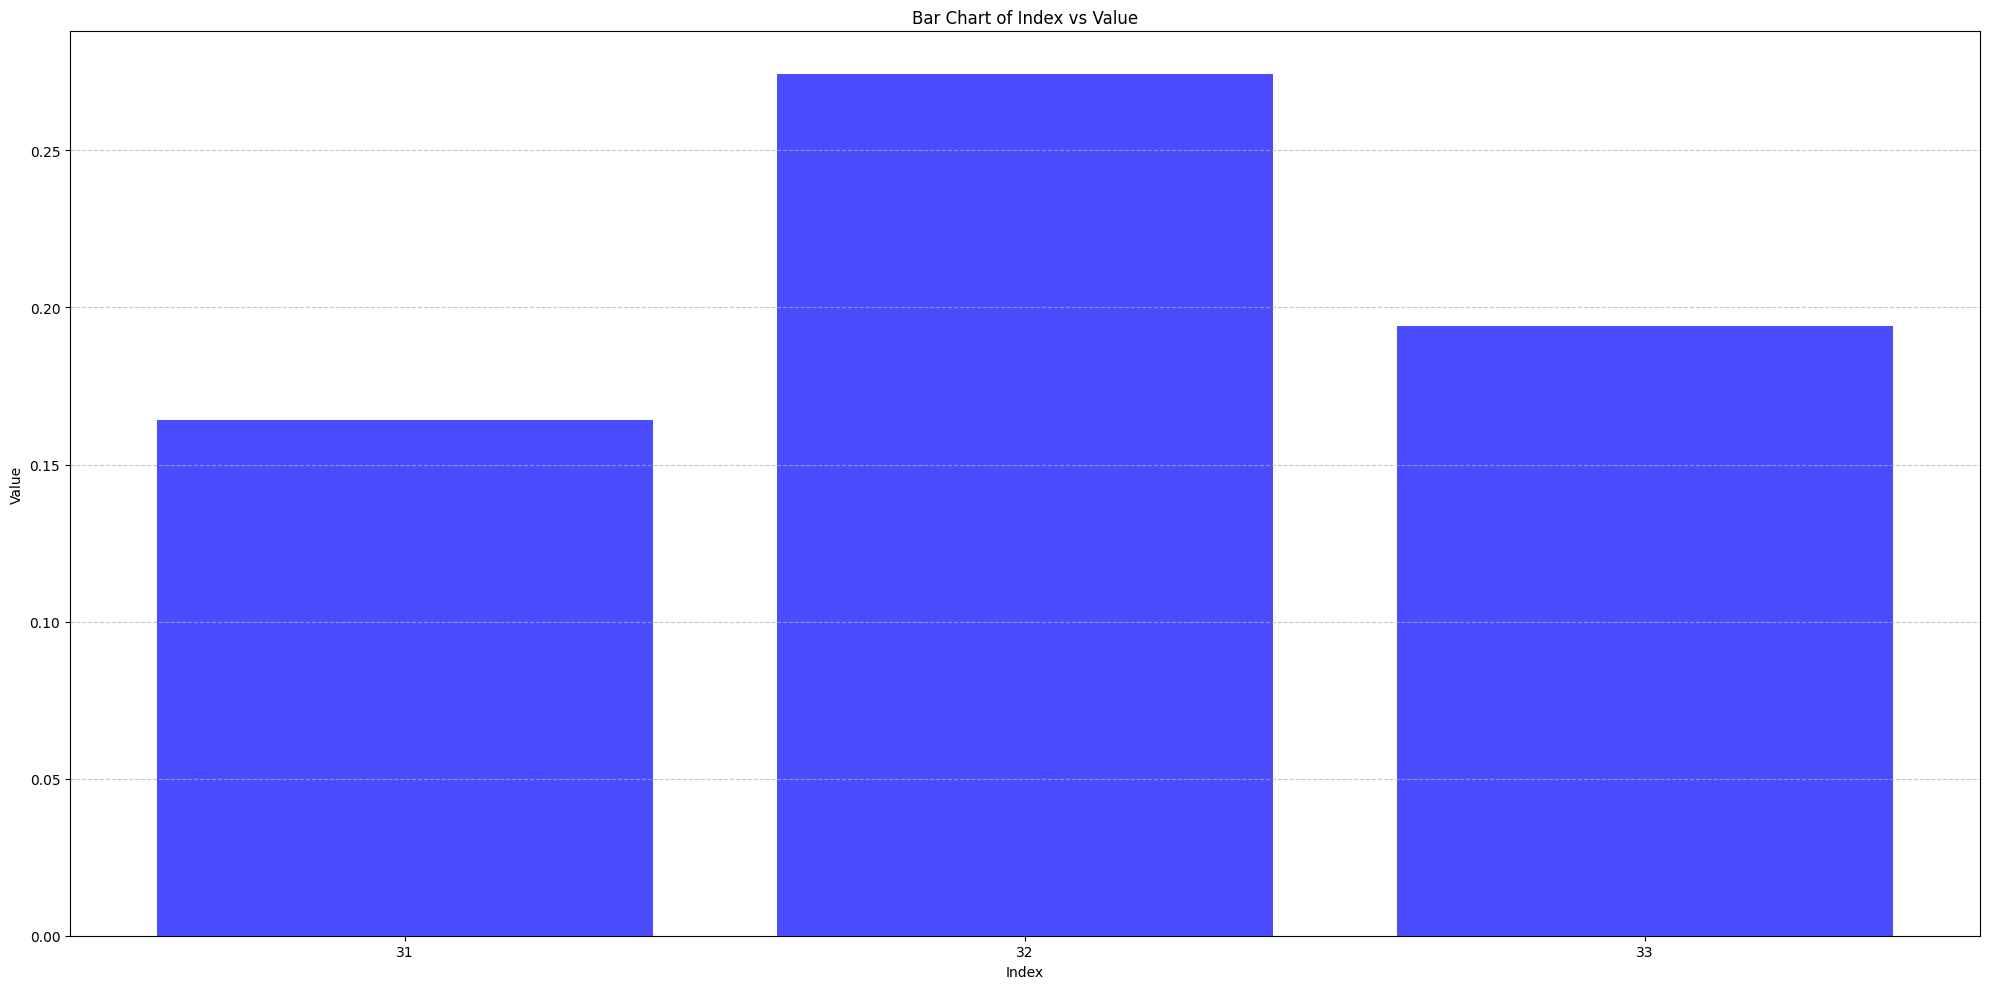

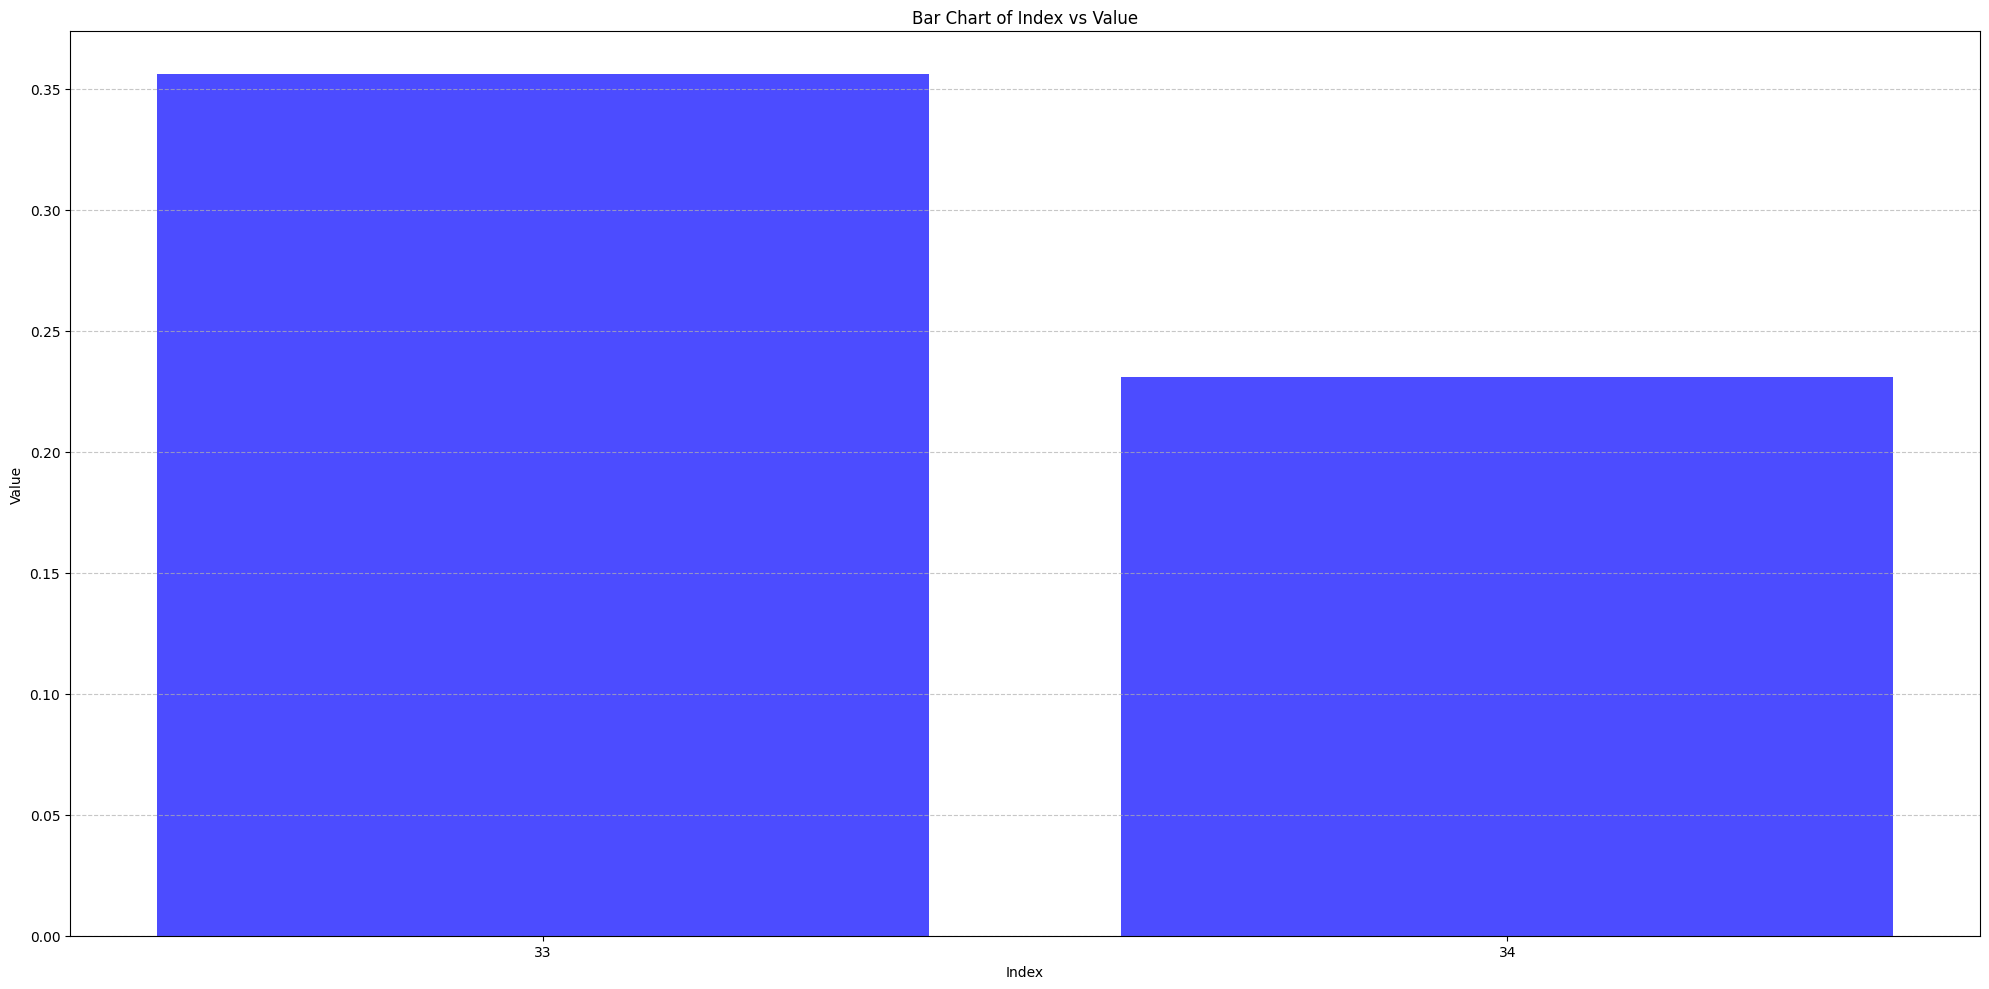

In [59]:
for q in [0, 1, 2]:
    indices, values = zip(*[(m[1], m[2]) for m in full_matches if m[0] == q])

    plt.figure(figsize=(20, 10))
    plt.bar(indices, values, color='blue', alpha=0.7)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title('Bar Chart of Index vs Value')
    plt.xticks(indices)  # Setting x-ticks to show each index
    plt.tight_layout()  # Adjust layout for better appearance
    plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.show()

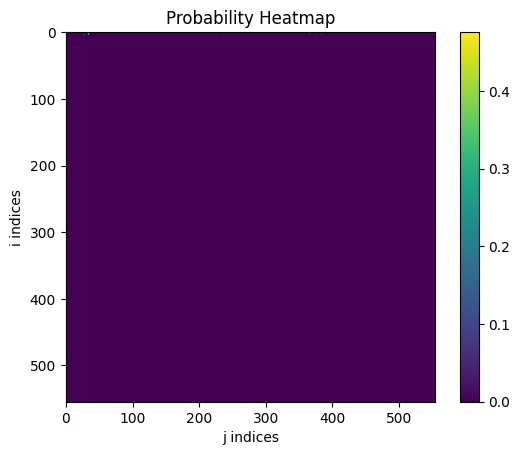

In [43]:
import torch

def construct_matrix(input_list):
    # Separate indices and probabilities
    i_indices, j_indices, probabilities = zip(*input_list)
    
    # Convert them to tensors
    i_indices = torch.tensor(i_indices, dtype=torch.long)
    j_indices = torch.tensor(j_indices, dtype=torch.long)
    probabilities = torch.tensor(probabilities)
    
    # Find the size of the matrix
    max_index = max(i_indices.max().item(), j_indices.max().item())
    
    # Create an empty matrix filled with zeros
    matrix = torch.zeros(max_index+1, max_index+1)
    
    # Use advanced indexing to fill the matrix
    matrix[i_indices, j_indices] = probabilities
    
    return matrix

chunks_matrix = construct_matrix(full_matches)

# Plotting the heatmap
plt.imshow(chunks_matrix, interpolation='nearest')
plt.colorbar()
plt.title("Probability Heatmap")
plt.xlabel("j indices")
plt.ylabel("i indices")
plt.show()

In [19]:
# let's pull out the first match
query, match, confidence = matches[0]
start_query = int(query * n_chars / 2)
end_query = start_query + n_chars
start_match = int(match * n_chars / 2)
end_match = start_match + n_chars

padding_chars = 20
query_window = prediction[start_query:end_query]
match_window = transcript[start_match:end_match]
expanded_match_window = transcript[max(0, start_match - padding_chars):(end_match + padding_chars)]

print("Query:")
print(query_window)
print()

print("Match:")
print(expanded_match_window)
print()

Query:
rt oan think part of your feeling that you can't rt of look right at him that he

Match:
o entertain as part of it, i think. and i think part of your feeling that you can’t look right at him, and that he doesn



In [20]:
recording = dataset.Recording(
    f"keanu-{offset_seconds}:{length_seconds}", 
    snippet[0], 
    clean_text_fn(expanded_match_window), 
    expanded_match_window, 
    None, 
    cfg.sampling_rate
)

batch = dataset.collate_fn([recording])
xs, ys, ys_original, ids = batch
(xs, ys, ys_original, ids)
alignments = aligner.align((xs, ys, ys_original, ids))
alignment = alignments[0]

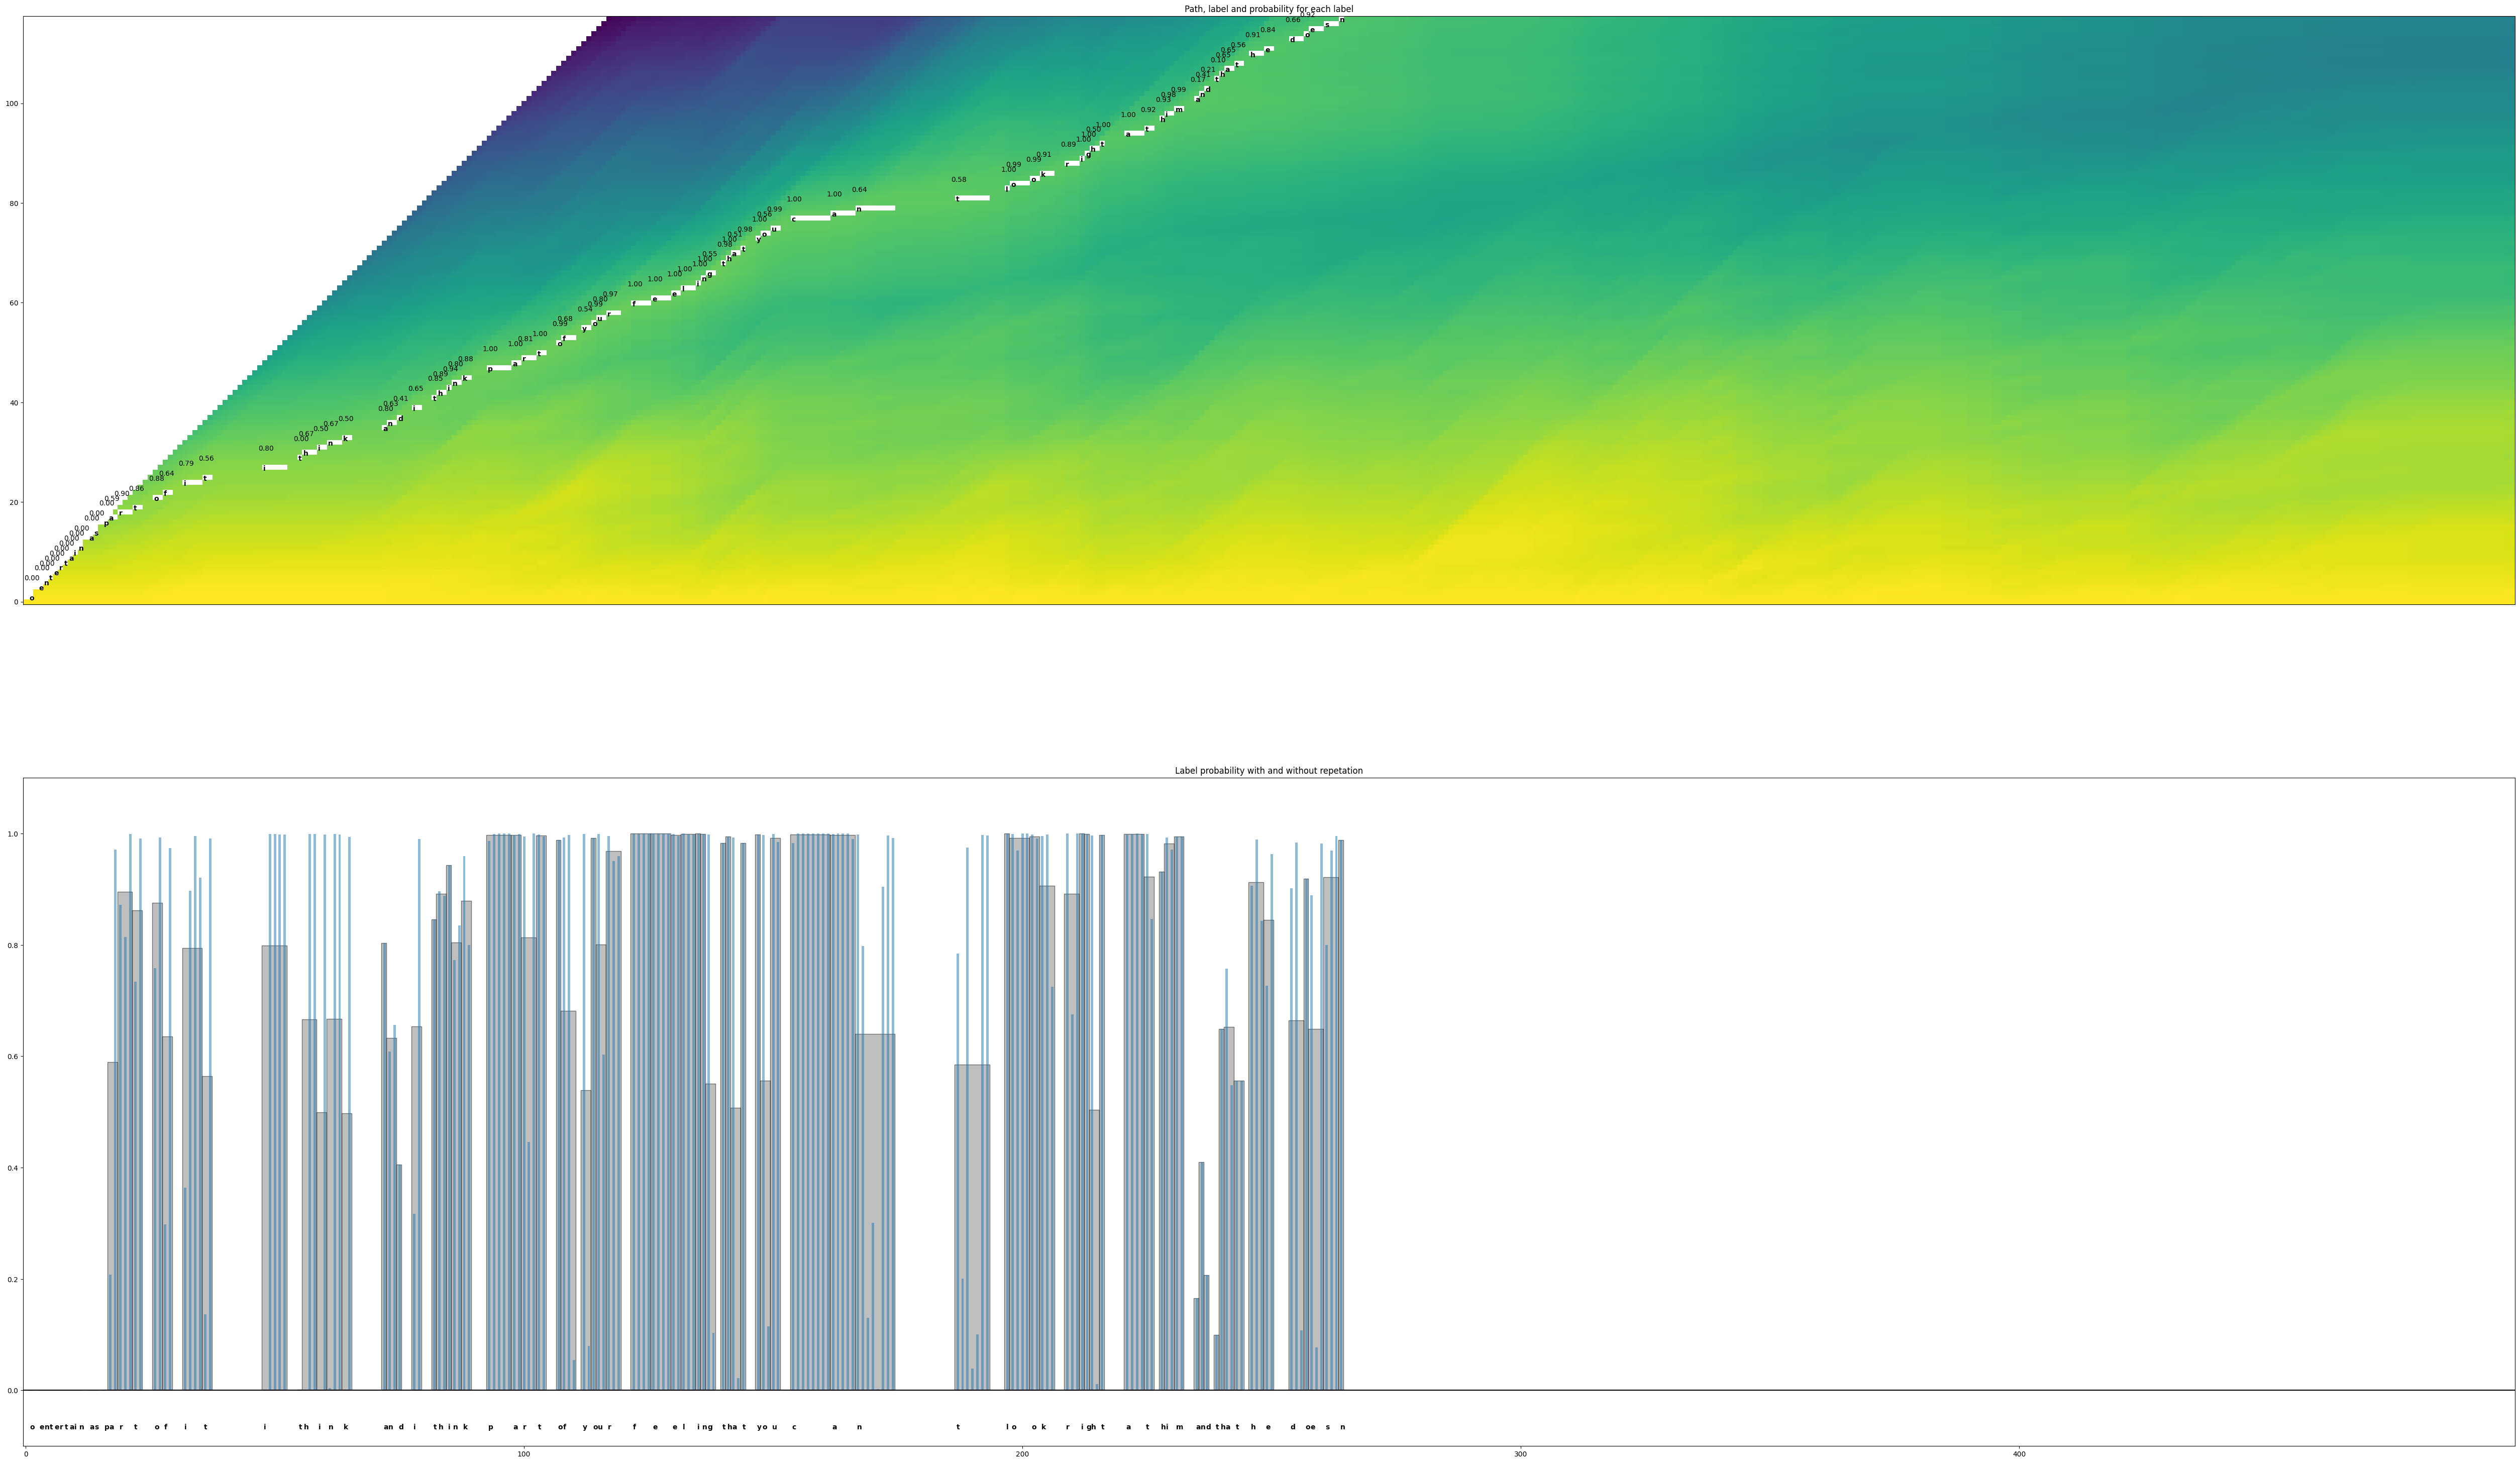

In [21]:
viz.plot_trellis_with_segments(alignment.trellis, alignment.chars_cleaned, ys[0], alignment.path);

In [22]:
alignment.words_cleaned

[Segment(label='o', start=0, end=1, score=0.00025789849632928963),
 Segment(label='entertain', start=2, end=11, score=1.4099239675147145e-05),
 Segment(label='as', start=12, end=14, score=6.161928316335737e-06),
 Segment(label='part', start=15, end=23, score=0.7292701672755356),
 Segment(label='of', start=25, end=29, score=0.7465953379869461),
 Segment(label='it', start=31, end=37, score=0.8316311348462477),
 Segment(label='i', start=47, end=52, score=0.7135928312605496),
 Segment(label='think', start=54, end=65, score=0.6466960976283778),
 Segment(label='and', start=71, end=75, score=0.6789939602216085),
 Segment(label='i', start=77, end=79, score=0.5971959568560123),
 Segment(label='think', start=81, end=89, score=0.8901654536073859),
 Segment(label='part', start=92, end=104, score=0.955412249479975),
 Segment(label='of', start=106, end=110, score=0.7982479989528656),
 Segment(label='your', start=111, end=119, score=0.8440380662679672),
 Segment(label='feeling', start=121, end=138, s

Let's have a look at specific word in here:

In [23]:
word = "feeling"
chars_cleaned_scores = [s.score for s in alignment.chars_cleaned]
i_start_word = [s.label for s in alignment.words_cleaned].index(word)
test_word_segment = alignment.words_cleaned[i_start_word]
frame_start = test_word_segment.start
i_start_char = [s.start for s in alignment.chars_cleaned].index(frame_start)
test_char_segment = alignment.chars_cleaned[i_start_char]

print(f"word level segment for '{word}': ", i_start_word, test_word_segment)
print(f"character level segment for '{word}': ", i_start_char, test_char_segment)

word level segment for 'feeling':  14 Segment(label='feeling', start=121, end=138, score=0.9461935497820377)
character level segment for 'feeling':  59 Segment(label='f', start=121, end=125, score=0.9998699277639389)


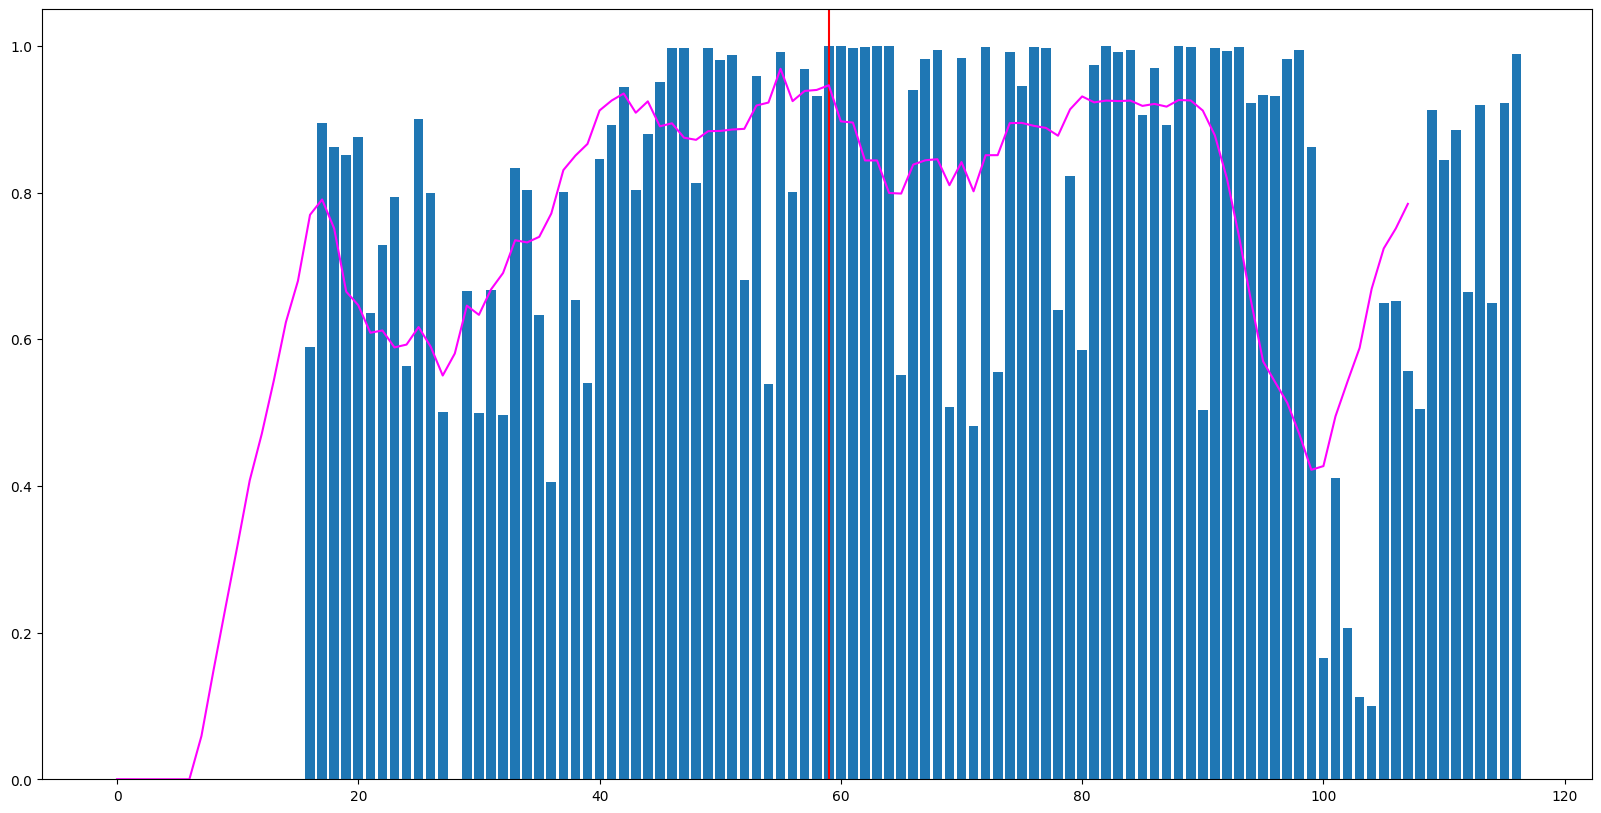

In [24]:
w = 10
smoothed = np.convolve(chars_cleaned_scores , np.ones(w), 'valid') / w

plt.figure(figsize=(20, 10))
plt.bar(range(len(chars_cleaned_scores )), chars_cleaned_scores )
plt.axvline(x=i_start_char, color='red')
plt.plot(smoothed, color="magenta")

The red line indicates where the test word starts. The blue lines are character level probabilities for the alignment. The magenta line is a smoothed version of that. 

Let's take a look at the selected word:

In [25]:
padding_ms = 20
padding_seconds = padding_ms / 1000

def show_word(word):
    start_seconds = max(0, alignment.model_frames_to_seconds(word.start) + padding_seconds)
    end_seconds = alignment.model_frames_to_seconds(word.end) + padding_seconds
    y, sr = utils.load_slice(fixtures_path / 'audio' / 'keanu.mp3', start_seconds, end_seconds)
    print(f"{word.label} ({word.start}:{word.end})")
    ipd.display(ipd.Audio(y, rate=sr))
        
show_word(test_word_segment)

feeling (121:138)


In [26]:
for w in alignment.words_cleaned:
    if w.score > 0.75:
        print(w.label)
    else:
        print(f'? {w.label}')

? o
? entertain
? as
? part
? of
it
? i
? think
? and
? i
think
part
of
your
feeling
? that
you
can
? t
look
right
at
him
? and
? that
he
doesn


# Issues

Some issues with the approach above. 

* First: doesn't seem to work at all lol
* We are indiscriminately chopping into pieces without paying attention to silences. Leading and trailing audio can and will be chopped into the middle of a word.
* Is there an issue with filling up the context windows on chunks?